In [4]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# from google.colab import drive
# drive.mount('/content/drive')

# #warnings.filterwarnings('ignore', category=FutureWarning)
# opath = 'yourpath'
merged_path = os.path.join(opath, 'Merged Dataframe')
calming_df = pd.read_csv(os.path.join(merged_path, "Calming_Merged_feature.csv"))
vexing_df = pd.read_csv(os.path.join(merged_path, "Vexing_Merged_feature.csv"))
music_df = pd.read_csv(os.path.join(merged_path, "Music_Merged_features.csv"))

# Drop the 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in calming_df.columns:
    calming_df = calming_df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in vexing_df.columns:
    vexing_df = vexing_df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0.1' in music_df.columns:
    music_df = music_df.drop(columns=['Unnamed: 0.1'])
if 'Unnamed: 0' in music_df.columns:
    music_df = music_df.drop(columns=['Unnamed: 0'])

print("Calming Data Shape:", calming_df.shape)
print("Vexing Data Shape:", vexing_df.shape)
print("Music Data Shape:", music_df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Calming Data Shape: (1760, 30)
Vexing Data Shape: (1760, 30)
Music Data Shape: (3520, 31)


In [5]:
from sklearn.model_selection import GroupShuffleSplit

def split_data(df, model_predicting = 'n_back'):
  '''
  In this function, we will split the data into training dataset, validation dataset, and testing dataset
  Args:
  df: Dataframe of raw data
  model_predicting: [str] indicating which model we are trying to split for
  '''

  if model_predicting == 'n_back':
    df_filtered = df[df['n_back'] != 'rest'].copy()
    # Assume n_back is already numerical (0 or 1) and does not need mapping
    y = df_filtered['n_back'].map({1: 1, 3: 0})
    columns_to_drop = [
        'n_back', 'subject_id', 'BlockNumber', 'TrialInBlock',
        'Session', 'Block', 'Trial', 'task' # These are from empatica_df, might not exist in merged df
    ]
    # Ensure only existing columns are dropped
    final_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
    X = df_filtered.drop(columns=final_columns_to_drop)
    # One-hot encode 'condition' columns
    X = pd.get_dummies(X, columns=['condition'], drop_first=True)

  elif model_predicting == 'condition':
    df_filtered = df[df['n_back'] != 'rest'].copy()
    y = df_filtered['condition'].map({'calming': 0, 'vexing': 1})
    columns_to_drop = ['BlockNumber', 'TrialInBlock', 'subject_id', 'condition', 'task', 'n_back']

    final_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
    X = df_filtered.drop(columns=final_columns_to_drop)

  groups = df_filtered['subject_id']

  # Split 1:Test set (10% of subjects)
  gss_test = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
  train_val_idx, test_idx = next(gss_test.split(X, y, groups))

  X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
  y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
  groups_train_val = groups.iloc[train_val_idx] # Get the subject list for the 90%

  # Split 2: Validation set (10% of total)
  val_split_size = 0.10 / 0.90
  gss_valid = GroupShuffleSplit(n_splits=1, test_size=val_split_size, random_state=42)
  train_idx, valid_idx = next(gss_valid.split(X_train_val, y_train_val, groups_train_val))

  # Create the final sets
  X_train, X_valid = X_train_val.iloc[train_idx], X_train_val.iloc[valid_idx]
  y_train, y_valid = y_train_val.iloc[train_idx], y_train_val.iloc[valid_idx]

  print("\n--- Split Verification (80/10/10) ---")
  print(f"Total rows in X_train: {len(X_train)} (~80%)")
  print(f"Total rows in X_valid: {len(X_valid)} (~10%)")
  print(f"Total rows in X_test:  {len(X_test)} (~10%)")

  print(f"\nTraining subjects:   {groups_train_val.iloc[train_idx].unique()}")
  print(f"Validation subjects: {groups_train_val.iloc[valid_idx].unique()}")
  print(f"Test subjects:       {groups.iloc[test_idx].unique()}")

  return X_train, X_valid, X_test, y_train, y_valid, y_test

# Generate splits for N-back task
calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test = split_data(calming_df)
vex_X_train, vex_X_valid, vex_X_test, vex_y_train, vex_y_valid, vex_y_test = split_data(vexing_df)

# Generate splits for Full Data (combining both)
full_df = pd.concat([calming_df, vexing_df], ignore_index=True)
full_X_train, full_X_valid, full_X_test, full_y_train, full_y_valid, full_y_test = split_data(full_df)


--- Split Verification (80/10/10) ---
Total rows in X_train: 1056 (~80%)
Total rows in X_valid: 352 (~10%)
Total rows in X_test:  352 (~10%)

Training subjects:   ['Subject6' 'Subject11' 'Subject8']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

--- Split Verification (80/10/10) ---
Total rows in X_train: 1056 (~80%)
Total rows in X_valid: 352 (~10%)
Total rows in X_test:  352 (~10%)

Training subjects:   ['Subject6' 'Subject8' 'Subject11']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

--- Split Verification (80/10/10) ---
Total rows in X_train: 2112 (~80%)
Total rows in X_valid: 704 (~10%)
Total rows in X_test:  704 (~10%)

Training subjects:   ['Subject6' 'Subject11' 'Subject8']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']



Feature correlations:
Correct              0.246588
HR_std               0.124619
Response_Time        0.107886
RESP_mean            0.059623
RESP_std             0.047054
SKT_std              0.039030
ECG_std              0.038174
EDA_std_empatica     0.032715
ACC_std              0.032237
EDA_std_biopac       0.029649
PPG_mean             0.028711
ECG_mean             0.026279
EMG_std              0.023868
BVP_std              0.022212
IBI_std              0.018356
TEMP_mean            0.018070
PPG_std              0.017382
SKT_mean             0.015683
IBI_mean             0.015456
EDA_mean_biopac      0.014946
HR_mean              0.011025
EMG_mean             0.009455
EDA_mean_empatica    0.006749
BVP_mean             0.004331
ACC_mean             0.003182
dtype: float64

Selecting features that have correlation > 0.05 with n-back label
Response_Time   -0.107886
Correct          0.246588
HR_std           0.124619
RESP_mean       -0.059623
dtype: float64


Feature correlations:
Co

/tmp/ipython-input-3602259646.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_df = prob_df.groupby('feature_bin')['target'].mean().reset_index()
/tmp/ipython-input-3602259646.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_df = prob_df.groupby('feature_bin')['target'].mean().reset_index()
/tmp/ipython-input-3602259646.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_df = prob_df.groupby('feat

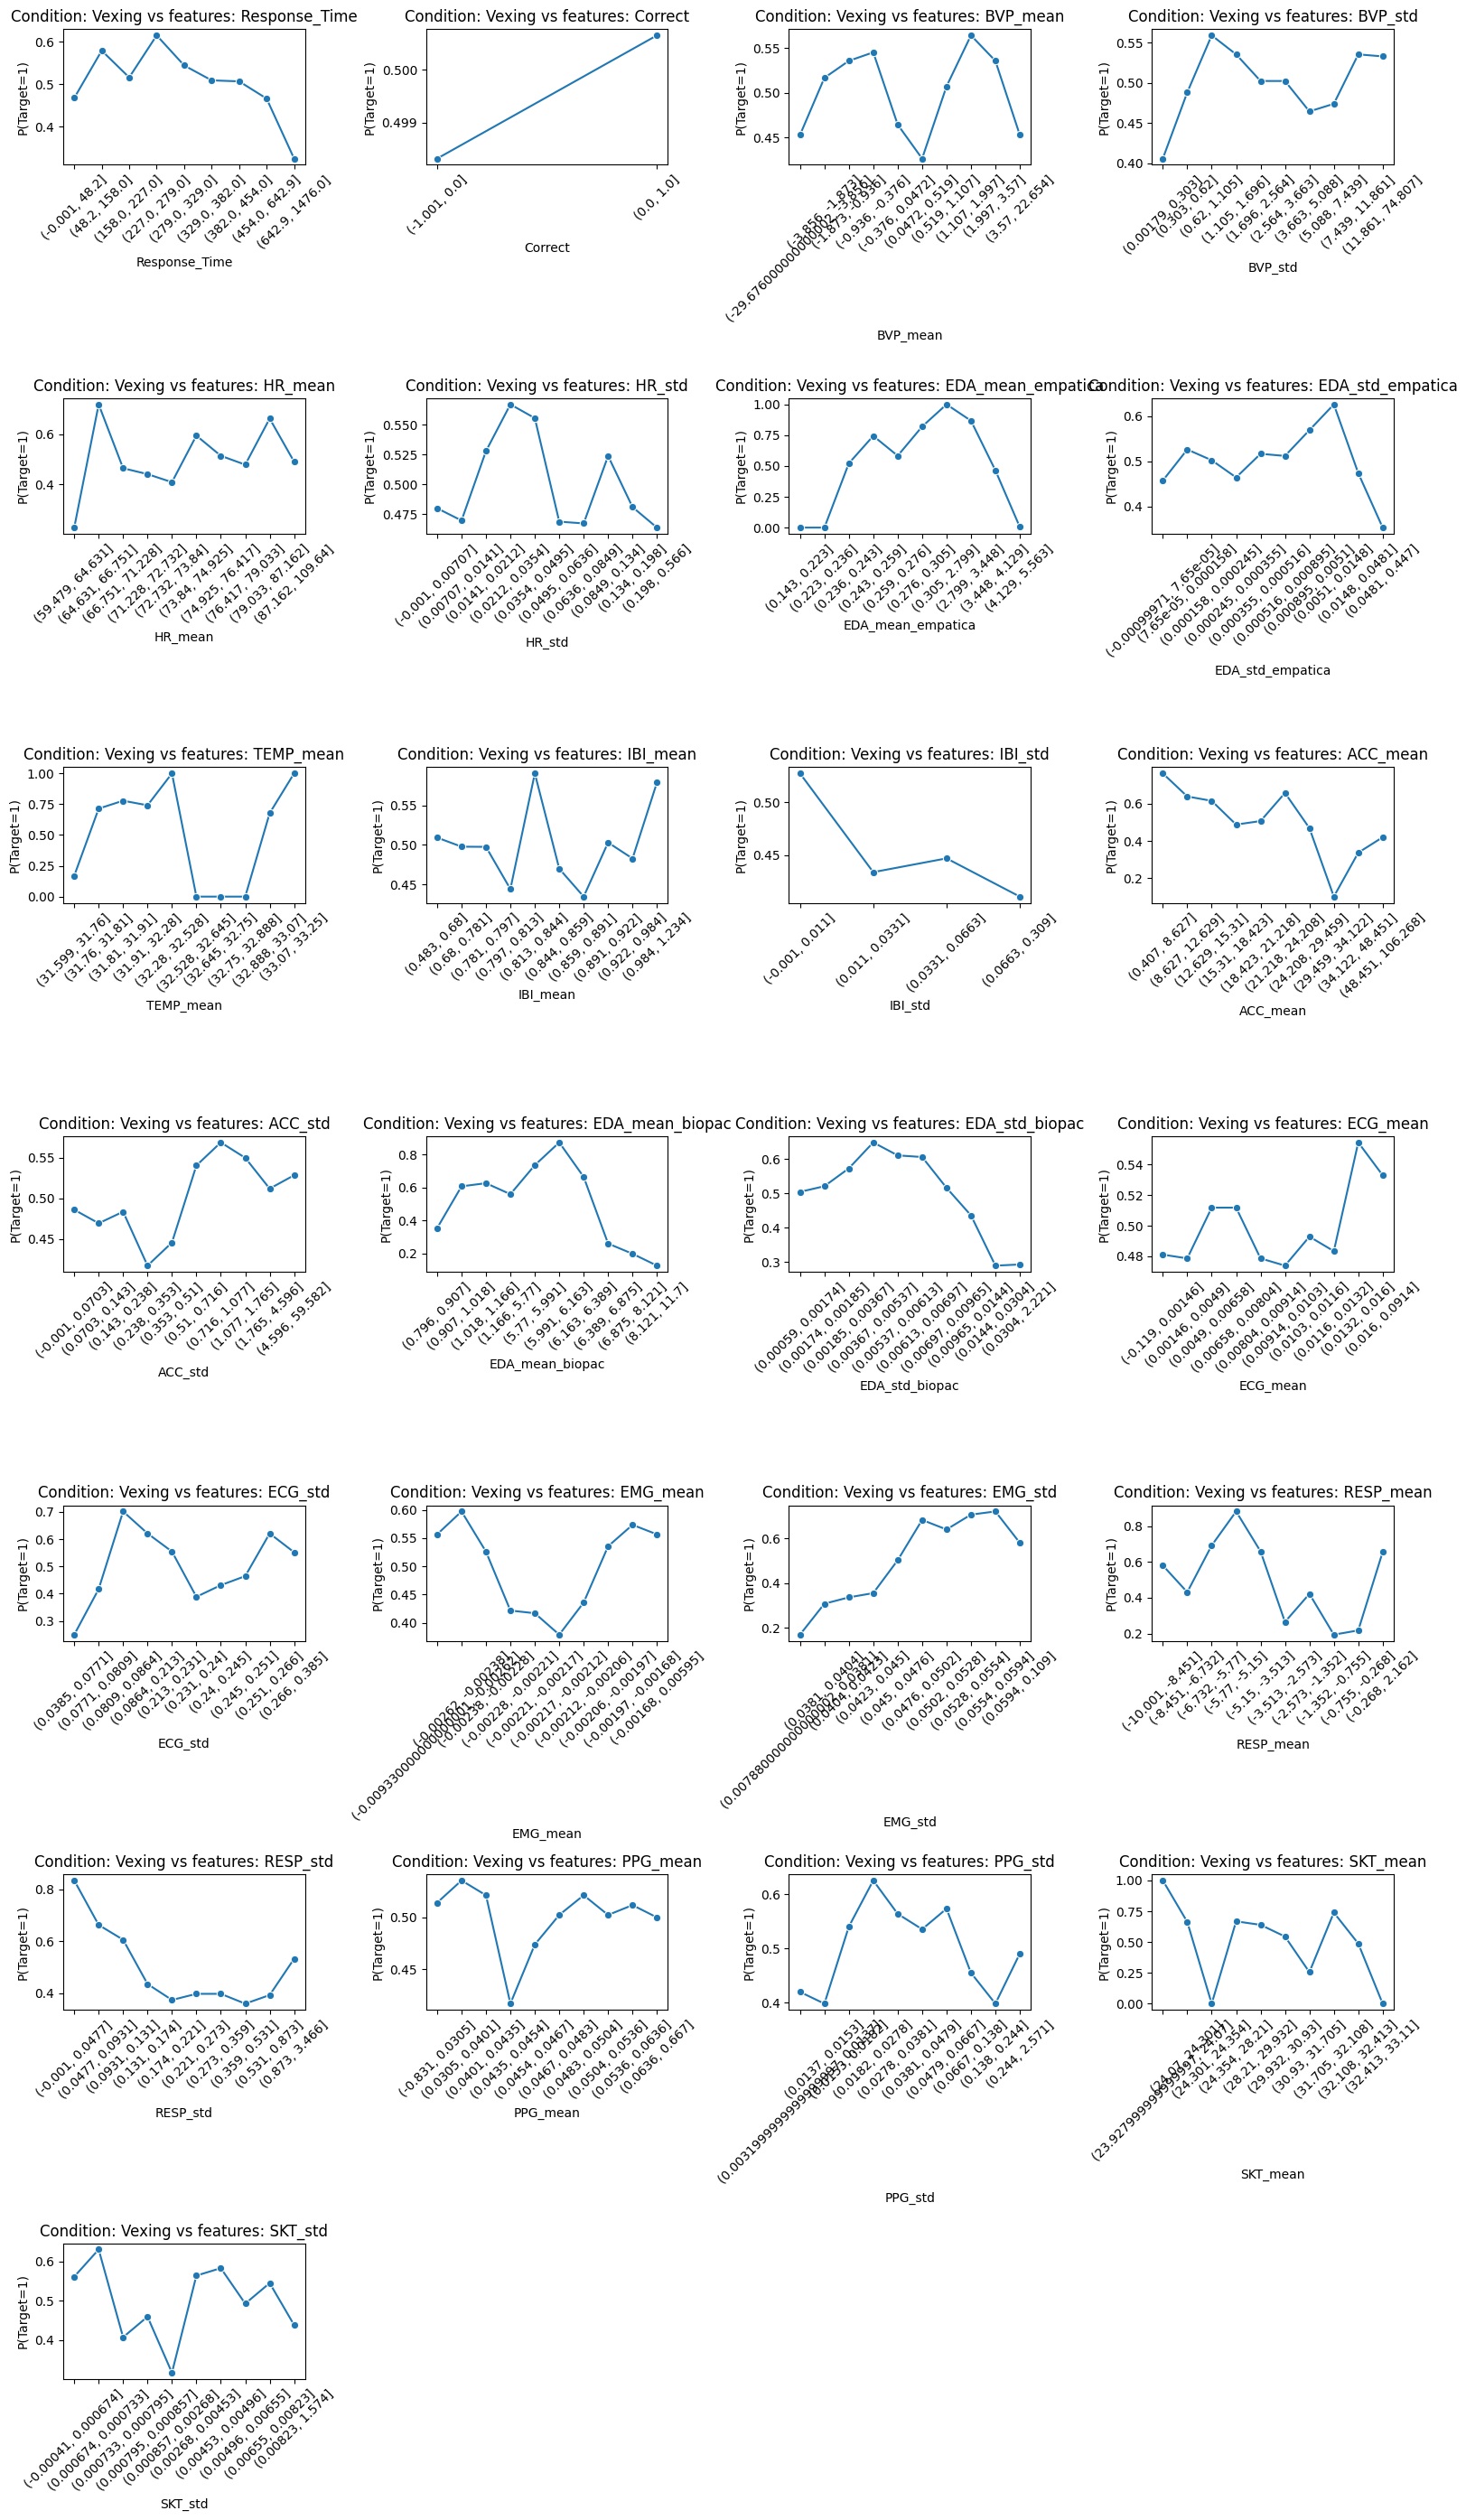


Feature correlations:
EMG_std              0.264050
ACC_mean             0.214605
RESP_mean            0.179511
SKT_mean             0.149297
EDA_mean_biopac      0.127050
EDA_mean_empatica    0.102751
EDA_std_empatica     0.097433
Response_Time        0.094664
EDA_std_biopac       0.091782
IBI_std              0.082228
RESP_std             0.075936
ACC_std              0.046023
IBI_mean             0.040558
HR_mean              0.038973
PPG_std              0.038420
BVP_std              0.018291
ECG_std              0.017857
ECG_mean             0.016256
Correct              0.016251
HR_std               0.010015
SKT_std              0.007220
PPG_mean             0.005666
BVP_mean             0.002152
EMG_mean             0.001151
TEMP_mean            0.000996
dtype: float64

Selecting features that have correlation > 0.05 with n-back label
Response_Time       -0.094664
EDA_mean_empatica   -0.102751
EDA_std_empatica    -0.097433
IBI_std             -0.082228
ACC_mean            -0.21

In [6]:
def plot_all_features_probability_trend(X_df, y_df, n_bins=10,
                                        title_prefix="Feature vs. Target (Probability/Trend)",
                                        save = False):

    if isinstance(y_df, pd.DataFrame):
        y_series = y_df.iloc[:, 0]
    else:
        y_series = y_df

    num_features = X_df.shape[1]
    ncols = 4
    nrows = (num_features + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, column in enumerate(X_df.columns):
        bins = pd.qcut(X_df[column], q=n_bins, duplicates='drop')
        prob_df = pd.DataFrame({'feature_bin': bins, 'target': y_series})
        prob_df = prob_df.groupby('feature_bin')['target'].mean().reset_index()

        sns.lineplot(x=prob_df['feature_bin'].astype(str), y=prob_df['target'], marker='o', ax=axes[i])
        axes[i].set_title(f"{title_prefix}: {column}")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel("P(Target=1)")
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    if save == True:
      plt.savefig("probability_feature.png")
    plt.show()

def feature_engineering(X_df, y_df, drop_threshold):

  X_df_feature_engineering = X_df.corrwith(y_df)

  print("\nFeature correlations:")
  print(abs(X_df_feature_engineering).sort_values(ascending=False))

  X_df_feature_engineering = X_df_feature_engineering[abs(X_df_feature_engineering) > drop_threshold]

  print("\nSelecting features that have correlation > {} with n-back label".format(drop_threshold))
  print(X_df_feature_engineering)
  print(f"\n{'='*40}")
  return X_df_feature_engineering.index.to_list()

calm_X_train_FE = feature_engineering(calm_X_train, calm_y_train, 0.05)
vex_X_train_FE = feature_engineering(vex_X_train, vex_y_train, 0.03)

# Create optimized datasets for N-back
calm_X_retrain = calm_X_train[calm_X_train_FE]
vex_X_retrain = vex_X_train[vex_X_train_FE]

calm_X_revalid = calm_X_valid[calm_X_train_FE]
vex_X_revalid = vex_X_valid[vex_X_train_FE]

calm_X_retest = calm_X_test[calm_X_train_FE]
vex_X_retest = vex_X_test[vex_X_train_FE]

### Music Condition Prediction
condition_X_train, condition_X_valid, condition_X_test, condition_y_train, condition_y_valid, condition_y_test = split_data(music_df, model_predicting='condition')

plot_all_features_probability_trend(condition_X_train, condition_y_train, title_prefix="Condition: Vexing vs features")

condition_FE = feature_engineering(condition_X_train, condition_y_train, 0.05)

# Create optimized datasets for Music
condition_X_train_FE = condition_X_train[condition_FE]
condition_X_valid_FE = condition_X_valid[condition_FE]
condition_X_test_FE = condition_X_test[condition_FE]

#KNN Building

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

def tune_and_eval_knn(X_train, y_train, X_valid, y_valid, X_test, y_test, k_values=None, cv_folds=5, scoring='f1'):
    if k_values is None:
        k_values = [1, 3, 5, 7, 9, 11, 15, 21]

    X_cv = pd.concat([X_train, X_valid], axis=0)
    y_cv = pd.concat([y_train, y_valid], axis=0)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    param_grid = {
        'knn__n_neighbors': k_values,
        'knn__weights': ['uniform', 'distance']
    }

    # multi-metric scoring: F1 and Accuracy
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv_folds,
        scoring={'f1': 'f1', 'accuracy': 'accuracy'},
        refit=scoring,    # model used will be the best by scoring metric
        n_jobs=-1
    )

    print(f"Running grid search for KNN (Refit on {scoring})...")
    grid.fit(X_cv, y_cv)

    print("\nBest parameters:", grid.best_params_)
    print(f"Best CV {scoring}: {grid.best_score_:.4f}")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)

    print("\n=== Test Set Evaluation ===")
    print(classification_report(y_test, y_pred_test, digits=4))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred_test))

    return best_model, grid

#N-Back

In [8]:
print("--- KNN: CALMING CONDITION (No Feature Selection) ---")
knn_calm_model, knn_calm_grid = tune_and_eval_knn(
    calm_X_train, calm_y_train,
    calm_X_valid, calm_y_valid,
    calm_X_test, calm_y_test,
    k_values=[1, 3, 5, 7, 9, 11, 15],
    cv_folds=5,
    scoring='f1'
)

print("\n--- KNN: VEXING CONDITION (No Feature Selection) ---")
knn_vex_model, knn_vex_grid = tune_and_eval_knn(
    vex_X_train, vex_y_train,
    vex_X_valid, vex_y_valid,
    vex_X_test, vex_y_test,
    k_values=[1, 3, 5, 7, 9, 11, 15],
    cv_folds=5,
    scoring='f1'
)

print("\n--- KNN: FULL DATASET (No Feature Selection) ---")
knn_full_model, knn_full_grid = tune_and_eval_knn(
    full_X_train, full_y_train,
    full_X_valid, full_y_valid,
    full_X_test, full_y_test,
    k_values=[1, 3, 5, 7, 9, 11, 15, 19],
    cv_folds=5,
    scoring='f1'
)

--- KNN: CALMING CONDITION (No Feature Selection) ---
Running grid search for KNN (Refit on f1)...

Best parameters: {'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Best CV f1: 0.5890

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.5885    0.6989    0.6390       176
           1     0.6294    0.5114    0.5643       176

    accuracy                         0.6051       352
   macro avg     0.6089    0.6051    0.6016       352
weighted avg     0.6089    0.6051    0.6016       352

Confusion matrix:
[[123  53]
 [ 86  90]]

--- KNN: VEXING CONDITION (No Feature Selection) ---
Running grid search for KNN (Refit on f1)...

Best parameters: {'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
Best CV f1: 0.5775

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       176
           1     0.5000    1.0000    0.6667       176

    accuracy                       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best parameters: {'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
Best CV f1: 0.6196

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.5781    0.3153    0.4081       352
           1     0.5293    0.7699    0.6273       352

    accuracy                         0.5426       704
   macro avg     0.5537    0.5426    0.5177       704
weighted avg     0.5537    0.5426    0.5177       704

Confusion matrix:
[[111 241]
 [ 81 271]]


In [9]:
print("--- KNN: CALMING CONDITION (With Feature Optimization) ---")
knn_calm_model_fe, knn_calm_grid_fe = tune_and_eval_knn(
    calm_X_retrain, calm_y_train,
    calm_X_revalid, calm_y_valid,
    calm_X_retest, calm_y_test,
    k_values=[1, 3, 5, 7, 9, 11, 15],
    cv_folds=5,
    scoring='f1'
)

print("\n--- KNN: VEXING CONDITION (With Feature Optimization) ---")
knn_vex_model_fe, knn_vex_grid_fe = tune_and_eval_knn(
    vex_X_retrain, vex_y_train,
    vex_X_revalid, vex_y_valid,
    vex_X_retest, vex_y_test,
    k_values=[1, 3, 5, 7, 9, 11, 15],
    cv_folds=5,
    scoring='f1'
)

--- KNN: CALMING CONDITION (With Feature Optimization) ---
Running grid search for KNN (Refit on f1)...

Best parameters: {'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Best CV f1: 0.6218

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.5983    0.7784    0.6765       176
           1     0.6829    0.4773    0.5619       176

    accuracy                         0.6278       352
   macro avg     0.6406    0.6278    0.6192       352
weighted avg     0.6406    0.6278    0.6192       352

Confusion matrix:
[[137  39]
 [ 92  84]]

--- KNN: VEXING CONDITION (With Feature Optimization) ---
Running grid search for KNN (Refit on f1)...

Best parameters: {'knn__n_neighbors': 15, 'knn__weights': 'distance'}
Best CV f1: 0.6472

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       176
           1     0.5000    1.0000    0.6667       176

    accuracy           

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


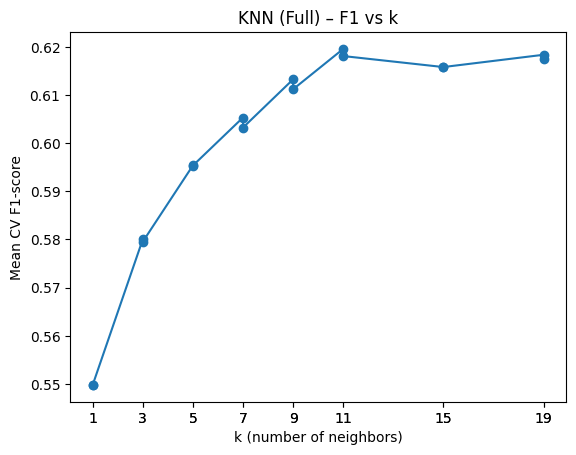

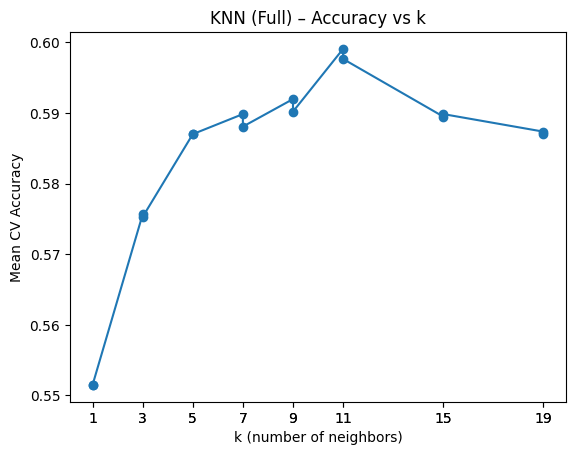

In [10]:
results = knn_full_grid.cv_results_

# k values (convert from masked/objects to ints)
k_list = [int(k) for k in results['param_knn__n_neighbors']]

mean_f1 = results['mean_test_f1']
mean_acc = results['mean_test_accuracy']

# 1) F1 vs k
plt.figure()
plt.plot(k_list, mean_f1, marker='o')
plt.xlabel("k (number of neighbors)")
plt.ylabel("Mean CV F1-score")
plt.title("KNN (Full) – F1 vs k")
plt.xticks(k_list)
plt.show()

# 2) Accuracy vs k
plt.figure()
plt.plot(k_list, mean_acc, marker='o')
plt.xlabel("k (number of neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.title("KNN (Full) – Accuracy vs k")
plt.xticks(k_list)
plt.show()

#Music

In [11]:
print("--- KNN: MUSIC CONDITION (No Feature Engineering) ---")
knn_music_model, knn_music_grid = tune_and_eval_knn(
    condition_X_train, condition_y_train,
    condition_X_valid, condition_y_valid,
    condition_X_test, condition_y_test,
    k_values=[1, 3, 5, 7, 9, 11, 15],
    cv_folds=5,
    scoring='accuracy'
)

--- KNN: MUSIC CONDITION (No Feature Engineering) ---
Running grid search for KNN (Refit on accuracy)...

Best parameters: {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Best CV accuracy: 0.5717

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.4780    0.5852    0.5262       352
           1     0.4652    0.3608    0.4064       352

    accuracy                         0.4730       704
   macro avg     0.4716    0.4730    0.4663       704
weighted avg     0.4716    0.4730    0.4663       704

Confusion matrix:
[[206 146]
 [225 127]]


In [12]:
print("--- KNN: MUSIC CONDITION (With Feature Engineering) ---")
knn_music_model_fe, knn_music_grid_fe = tune_and_eval_knn(
    condition_X_train_FE, condition_y_train,
    condition_X_valid_FE, condition_y_valid,
    condition_X_test_FE, condition_y_test,
    k_values=[1, 3, 5, 7, 9, 11, 15],
    cv_folds=5,
    scoring='accuracy'
)

--- KNN: MUSIC CONDITION (With Feature Engineering) ---
Running grid search for KNN (Refit on accuracy)...

Best parameters: {'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Best CV accuracy: 0.6963

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.1074    0.1193    0.1131       352
           1     0.0096    0.0085    0.0090       352

    accuracy                         0.0639       704
   macro avg     0.0585    0.0639    0.0610       704
weighted avg     0.0585    0.0639    0.0610       704

Confusion matrix:
[[ 42 310]
 [349   3]]


<Figure size 1200x500 with 0 Axes>

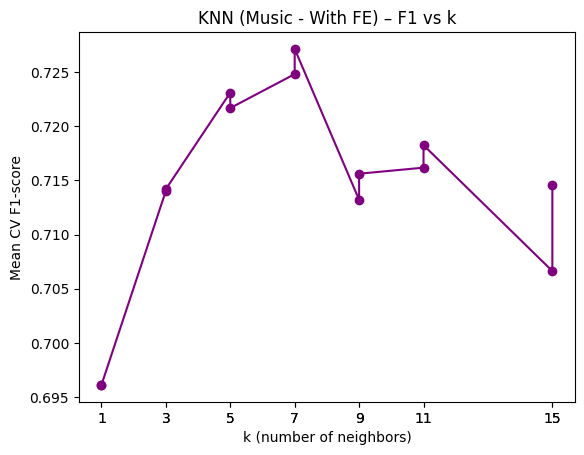

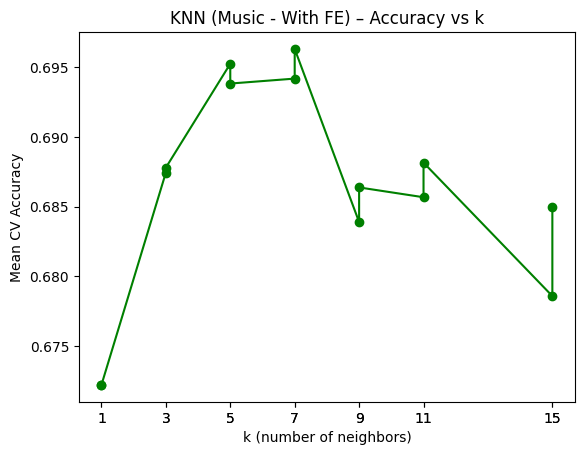

In [13]:
# --- Plotting Results for Music Classification (With Feature Engineering) ---

results_music_fe = knn_music_grid_fe.cv_results_

# k values
k_list = [int(k) for k in results_music_fe['param_knn__n_neighbors']]

mean_f1_fe = results_music_fe['mean_test_f1']
mean_acc_fe = results_music_fe['mean_test_accuracy']

plt.figure(figsize=(12, 5))

# 1) F1 vs k
plt.figure()
plt.plot(k_list, mean_f1_fe, marker='o', color='purple')
plt.xlabel("k (number of neighbors)")
plt.ylabel("Mean CV F1-score")
plt.title("KNN (Music - With FE) – F1 vs k")
plt.xticks(k_list)
plt.show()

# 2) Accuracy vs k
plt.figure()
plt.plot(k_list, mean_acc_fe, marker='o', color='green')
plt.xlabel("k (number of neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.title("KNN (Music - With FE) – Accuracy vs k")
plt.xticks(k_list)
plt.show()

